In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
import zipfile

# Unzip file
with zipfile.ZipFile('/content/drive/MyDrive/pdf_json.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extract')


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
%%time
import os
import json
import pandas as pd
import multiprocessing as mp
from multiprocessing import Pool

# Function to convert JSON to text
def json2text(filename):
    with open(filename, 'r') as file:
        paper_content = json.load(file)

    body_text = ""
    abstract = ""
    title = ""

    # Get the paper_id
    paper_id = paper_content.get('paper_id', '')

    # Get the title
    title = paper_content.get('title', '')

    # Get the abstract
    if 'abstract' in paper_content:
        for abs in paper_content['abstract']:
            abstract += abs['text']

    # Get the body text
    if 'body_text' in paper_content:
        for bt in paper_content['body_text']:
            body_text += bt['text']

    return (f'{title} {abstract} {body_text}').lower()

# Function to write converted text to file
def write_file(filename):
    # Convert JSON to text
    content = json2text(filename)

    # Define the output file path
    base_name = os.path.splitext(os.path.basename(filename))[0]
    output_dir = '/content/pdf_text'  # desired output directory
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    output_file = os.path.join(output_dir, f'{base_name}.txt')

    # Writing the content to a .txt file
    with open(output_file, 'w') as file:
        file.write(content)

# Function for parallel processing
def par_write(files):
    """
    Read a chunk of files and let the cores of your machine
    do the job of format conversion in parallel
    """
    cpu_count = os.cpu_count()
    p = Pool(processes=cpu_count)
    p.map(write_file, files, chunksize=16)
    p.close()

# Directory path for JSON files
dir_path = '/content/extract/pdf_json'

# List all JSON files in the directory
json_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.json')]

# Process the files in parallel
par_write(json_files)


CPU times: user 5.13 s, sys: 566 ms, total: 5.7 s
Wall time: 1min 46s


In [ ]:
# Delete the folder and its contents using shell command
!rm -rf /content/extract

In [ ]:
c=0
for items in os.listdir('/content/pdf_text'):
  c+=1
c

56528

In [ ]:
import re
def remove_urls(text):
  '''removes all urls and email ids using regular expression'''

  url_pattern = r'https?://\S+|www\.\S+'
  email_id_pattern=r"\S*@\S*\s?"
  clean_text=re.sub(url_pattern, '', text)
  clean_text=re.sub(email_id_pattern, '', clean_text)

  return clean_text

def remove_single_letters(text):
  '''removes all single letters except a '''
  single_letters= r'\b[b-zB-Z]\b'
  cleaned_text = re.sub(single_letters, '', text)
  return cleaned_text

def remove_num_spl_char(text):
  '''removes all numeric and special characters'''
  corpus_num=re.sub(r'\d+', '', text)
  return re.sub('[^\w\s]', '', corpus_num)

def remove_whitespace(text):
  '''it removes all extra whitespace'''
  return " ".join(text.split())

In [ ]:
%%time
import os
import re
from multiprocessing import Pool

def preprocess(text):

    rem_urls=remove_urls(text)
    rem_num_spl_char=remove_num_spl_char(rem_urls)
    rem_singlechar=remove_single_letters(rem_num_spl_char)
    cleaned_text=remove_whitespace(rem_singlechar)

    return cleaned_text


def preprocess_file(filename):
    """
    Read the content of a file, preprocess it, and save the cleaned text back to the file.
    """
    with open(filename, 'r') as file:
        text = file.read()
          # Preprocess text
    content = preprocess(text)

    with open(filename, 'w') as file:
        file.write(content)

def par_write(files):
    """
    Process a list of files in parallel and save the cleaned text back to the files.
    """
    cpu_count = os.cpu_count()
    p = Pool(processes=cpu_count)
    p.map(preprocess_file, files, chunksize=50)
    p.close()

# Example usage
dir_path = '/content/pdf_text'
txt_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.txt')]
par_write(txt_files)


CPU times: user 4.05 s, sys: 454 ms, total: 4.5 s
Wall time: 5min 37s


In [ ]:
from tqdm import tqdm
'''saving the final corpus in my drive by concat. all preprocessed .txt file'''

dir = "/content/drive/MyDrive/Assignment1_corpus"  # Specify the output file path

# Open the output file in write mode
with open(dir, 'a') as output_file:
    for file_path in tqdm(txt_files, desc="Reading files"):
        try:
            with open(file_path, 'r') as f:
                content = f.read()
                output_file.write(content)  # Write the content of each file to the output file
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")


Reading files: 100%|██████████| 56528/56528 [00:20<00:00, 2789.95it/s]


In [ ]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from collections import Counter
import gc
from nltk.tokenize import word_tokenize
from collections import defaultdict
import nltk


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

def tokenize_and_update_vocab(files, batch_size=100):
    """
    Tokenizes text files in batches and updates the vocabulary with word frequencies incrementally.

    Args:
        files (list): List of file paths to be processed.
        batch_size (int): Number of files to process in each batch to manage memory usage.
        stop_words: to remove stop words from the list of tokens

    Returns:
        tuple:
            - vocab (dict): A dictionary where keys are words and values are their respective frequencies in the corpus.
            - token_count (list): A list of cumulative token counts at every 10,000 tokens processed.
            - cum_vocab_count (list): A list of cumulative unique word counts (vocabulary size) at every 10,000 tokens processed.
    """
    vocab = defaultdict(int)
    word_count = 0
    token_count = []
    cum_vocab_count = []

    # Process files in batches
    for start in range(0, len(files), batch_size):
        batch_files = files[start:start + batch_size]
        for file_path in batch_files:
            with open(file_path, 'r') as f:
                text = f.read()

            # Tokenize the text
            tokens = word_tokenize(text)
            # Update vocabulary and counts
            for token in tokens:
              vocab[token] += 1
              word_count += 1
              if word_count % 10000 == 0:
                    token_count.append(word_count)
                    cum_vocab_count.append(len(vocab))


        # Clear temporary variables and force garbage collection
        del tokens
        gc.collect()
    if word_count % 10000 != 0:
      token_count.append(word_count)
      cum_vocab_count.append(len(vocab))

    return vocab, token_count, cum_vocab_count

# Directory containing the preprocessed text files
dir_path = '/content/pdf_text'

# List all files in the directory
files = [os.path.join(dir_path, item) for item in os.listdir(dir_path) if item.endswith('.txt')]

# Call the function to process files and update vocabulary
vocab, token_count, cum_vocab_count = tokenize_and_update_vocab(files, batch_size=200)

In [ ]:
total_tokens=0
for i in vocab.keys():
  total_tokens+=vocab[i]

In [ ]:
def weight_rank(vocab,total_tokens):
  '''
    Calculates the weighted term frequency for each word in the vocabulary
    and ranks the words based on their term frequency.

    Args:
    vocab (dict): A dictionary with words as keys and their frequencies as values.
    tokens (list): A list of tokens representing the entire corpus.

    Returns:
    dict: A dictionary with words as keys and their weighted term frequency as values.
    list: A list of tuples where each tuple contains a word, its frequency, its weighted TF, and its rank.
    '''
  weighted_tf={word: freq/total_tokens for word,freq in vocab.items()}
  sorted_words = sorted(weighted_tf.items(), key=lambda x: x[1],reverse=True)
  ranks,frequencies=zip(*[(i+1,freq) for i,(word,freq) in enumerate(sorted_words)])

  ranked_list = [(word, vocab[word],weighted_tf[word], rank) for (word, _), rank in zip(sorted_words, ranks)]

  return weighted_tf, ranked_list

In [ ]:
%%time
weighted_tf, ranked_list=weight_rank(vocab,total_tokens)

df = pd.DataFrame(ranked_list, columns=['Word', 'Frequency','Weighted TF', 'Rank'])
top_50_df = df.head(50)

top_50_df

CPU times: user 10.9 s, sys: 1.17 s, total: 12.1 s
Wall time: 12.2 s


,Word,Frequency,Weighted TF,Rank
0,the,11997192,0.056785,1
1,of,8284369,0.039212,2
2,and,6963733,0.032961,3
3,in,5439055,0.025744,4
4,to,4718208,0.022332,5
5,a,3682387,0.017430,6
6,for,2299839,0.010886,7
7,with,2282460,0.010803,8
8,is,2180273,0.010320,9
9,that,1761060,0.008335,10


Find the weighted term frequency for every word in the corpus and order
it according to its rank using Zipf’s Law. Find the value of the α using
the data obtained from the previous step

In [ ]:
ranks = [item[3] for item in ranked_list]
frequencies = [item[1] for item in ranked_list]

# Calculate log-transformed values
log_rank = np.log(ranks)
log_freq = np.log(frequencies)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_rank, log_freq)

# Estimate alpha
alpha = -slope
print(f"Estimated value of α: {alpha:.2f}")

Estimated value of α: 1.24


Text(0.5, 1.0, 'Rank-Frequency Distribution')

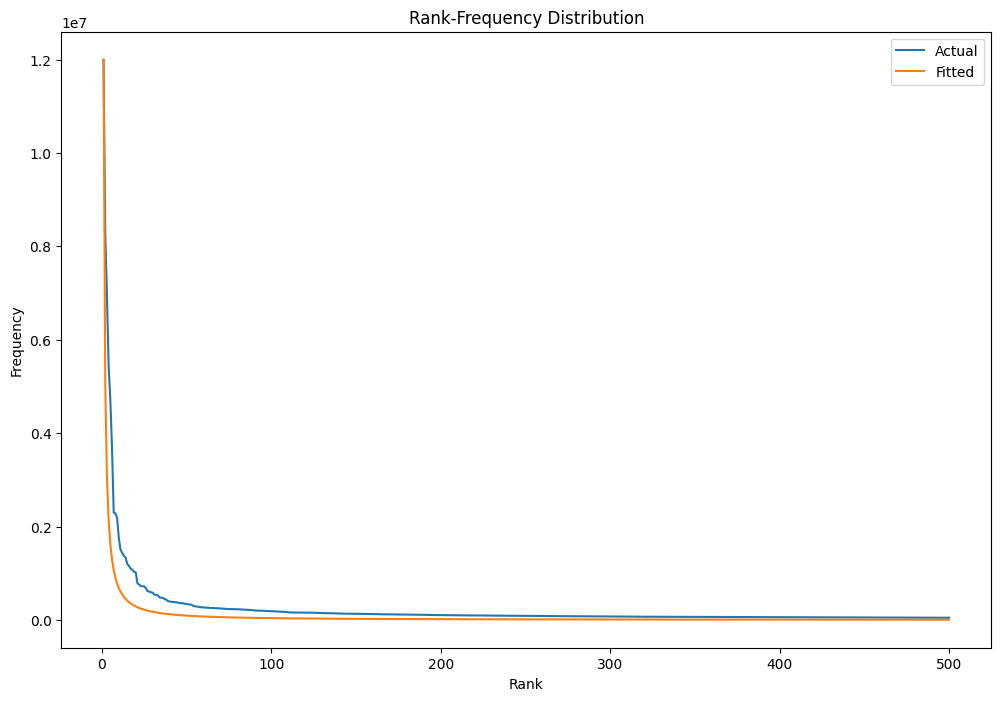

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df['Rank'][:500], df['Frequency'][:500])
plt.plot(df['Rank'][:500], df['Frequency'][:500][0]/(df['Rank'][:500]**alpha))
plt.legend(['Actual','Fitted'])
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Rank-Frequency Distribution')


In [ ]:
##Print number of tokens and vocabulary
print("Number of tokens :",total_tokens)
print("Vocabulary_size :",len(vocab.keys()))

Number of tokens : 211272427
Vocabulary_size : 2081654


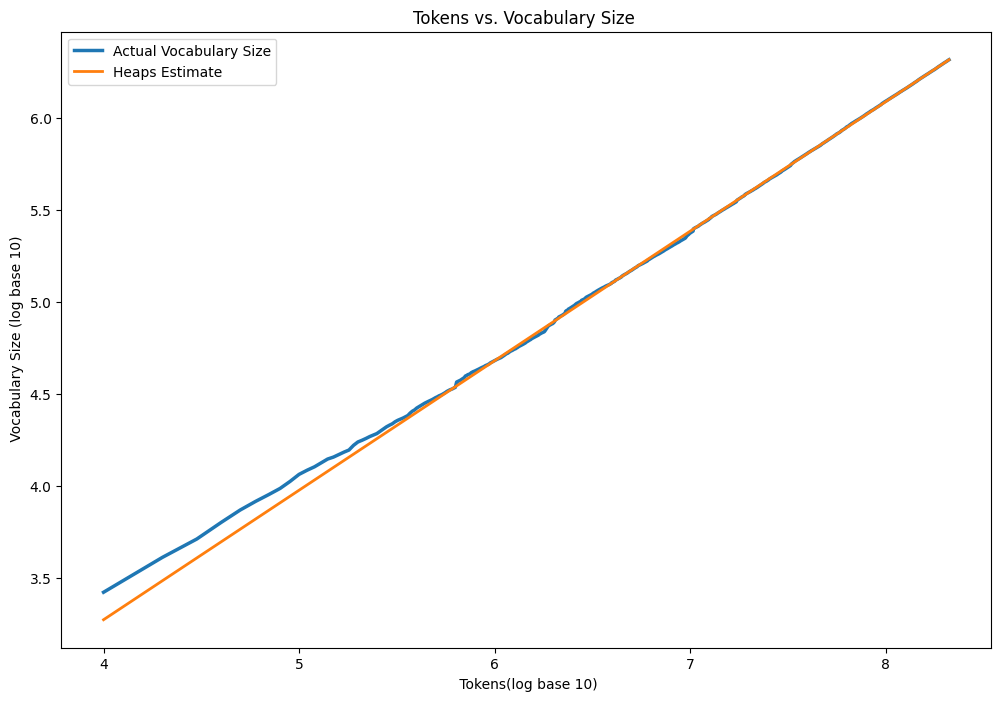

In [ ]:
# Log-transform the data
log_vocab_counts = np.log10(cum_vocab_count)
log_token_counts = np.log10(token_count)
slope, intercept, r_value, p_value, std_err = linregress(log_token_counts,log_vocab_counts)
beta=slope
log10_k=intercept
estimate_vocab=[log10_k+beta * i for i in log_token_counts]

plt.figure(figsize=(12, 8))
plt.plot(log_token_counts, log_vocab_counts, linewidth=2.5, label='Actual Vocabulary Size')  # Thicker blue line
plt.plot(log_token_counts, estimate_vocab, linewidth=2, label='Heaps Estimate')

# Add labels, title, and legend
plt.xlabel(' Tokens(log base 10)')
plt.ylabel(' Vocabulary Size (log base 10)')
plt.title('Tokens vs. Vocabulary Size ')
plt.legend()



In [ ]:
#Cumulative Vocabulary Count at every 10000 words
cum_vocab_count

[2632,
 4075,
 5130,
 6319,
 7377,
 8223,
 8952,
 9668,
 10560,
 11528,
 12148,
 12679,
 13332,
 13970,
 14319,
 14787,
 15247,
 15637,
 16589,
 17303,
 17678,
 18085,
 18520,
 18876,
 19222,
 19803,
 20384,
 20916,
 21350,
 21734,
 22294,
 22708,
 23013,
 23341,
 23703,
 24096,
 24846,
 25450,
 25857,
 26476,
 26898,
 27293,
 27715,
 28151,
 28502,
 28818,
 29128,
 29434,
 29820,
 30183,
 30480,
 30855,
 31105,
 31408,
 31763,
 32139,
 32589,
 32909,
 33223,
 33453,
 33697,
 34024,
 34294,
 36664,
 36965,
 37293,
 37559,
 37965,
 38406,
 38761,
 39572,
 39797,
 40223,
 40412,
 40675,
 41235,
 41547,
 41833,
 42028,
 42295,
 42552,
 42845,
 43115,
 43429,
 43690,
 43982,
 44217,
 44430,
 44794,
 45084,
 45272,
 45511,
 45793,
 46072,
 46549,
 46844,
 47093,
 47387,
 47648,
 47926,
 48171,
 48445,
 48728,
 48942,
 49127,
 49307,
 49613,
 49845,
 50165,
 50490,
 50833,
 51188,
 51563,
 51868,
 52252,
 52462,
 52650,
 53056,
 53408,
 53684,
 54052,
 54207,
 54430,
 54681,
 54990,
 55268,
